In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import os
import random
import pandas as pd 
import random
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

In [3]:
set_seed()

# Обучаем автоэнкодер

In [4]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=32)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=32)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [5]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [7]:
loss_fn = torch.nn.MSELoss()

lr= 0.001

d = 6

vae = Autoencoder(d)
params_to_optimize = [
    {'params': vae.encoder.parameters()},
    {'params': vae.decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


Autoencoder(
  (encoder): Encoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (6): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=6, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=6, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened

In [8]:
def train_epoch(vae, device, dataloader, optimizer):
    vae.train()
    train_loss = 0.0
    for x, _ in tqdm(dataloader): 
        x = x.to(device)
        x_hat = vae(x)
        loss = loss_fn(x_hat, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(dataloader.dataset)

In [9]:
def test_epoch(vae, device, dataloader):
    vae.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, _ in tqdm(dataloader):
            x = x.to(device)
            encoded_data = vae.encoder(x)
            x_hat = vae(x)
            loss = loss_fn(x_hat, x)
            val_loss += loss.item()
    return val_loss / len(dataloader.dataset)

In [10]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()  

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 1/40 	 train loss 0.000506 	 val loss 0.000247


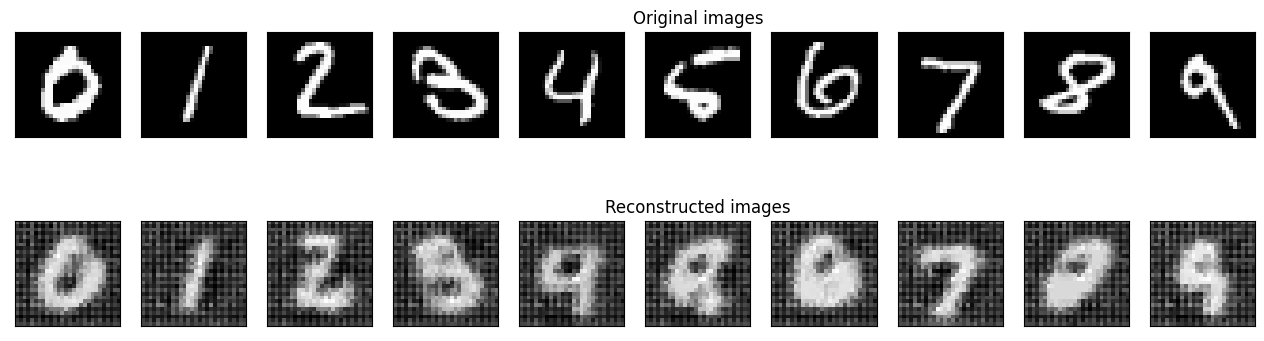

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 2/40 	 train loss 0.000197 	 val loss 0.000169


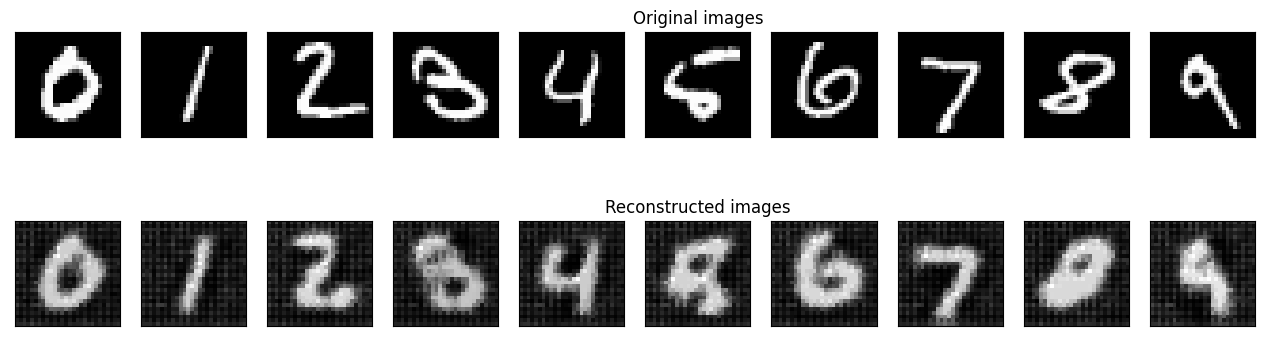

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 3/40 	 train loss 0.000158 	 val loss 0.000151


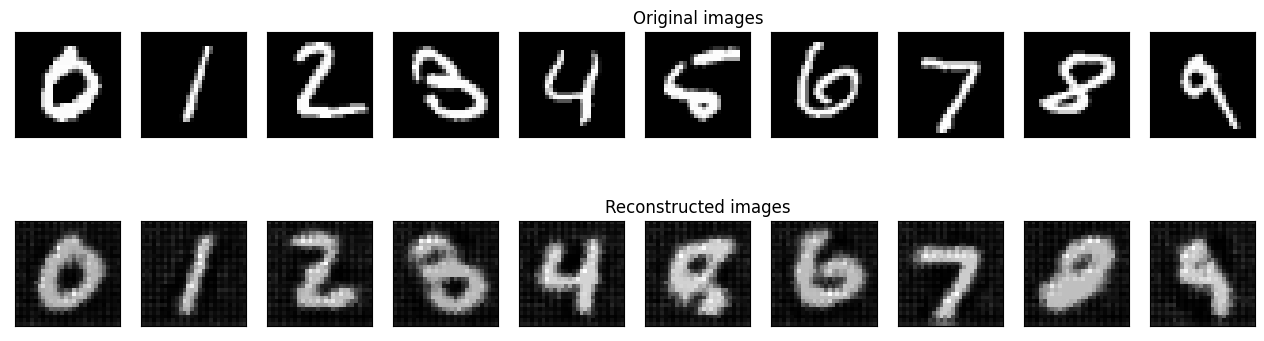

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 4/40 	 train loss 0.000144 	 val loss 0.000139


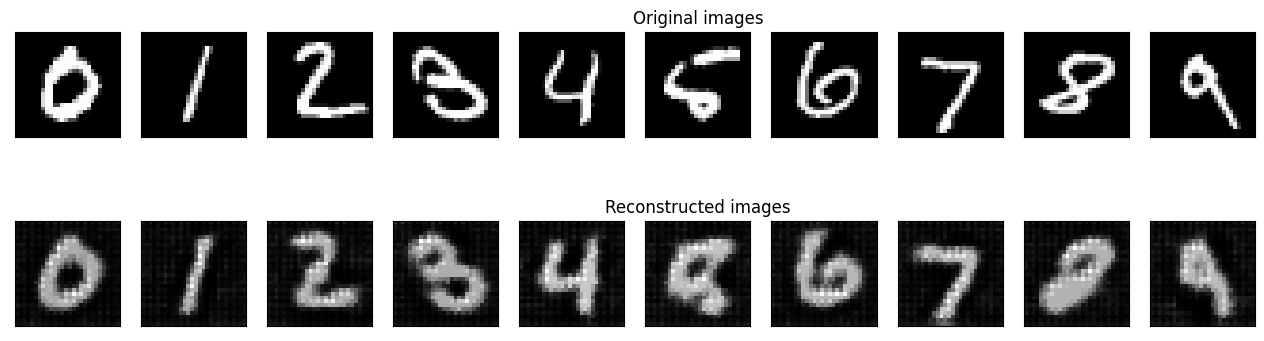

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 5/40 	 train loss 0.000134 	 val loss 0.000131


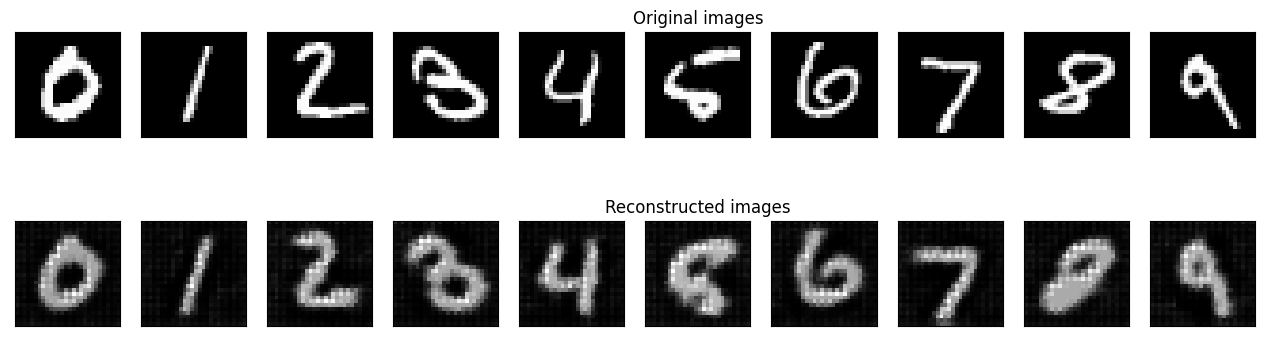

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 6/40 	 train loss 0.000126 	 val loss 0.000123


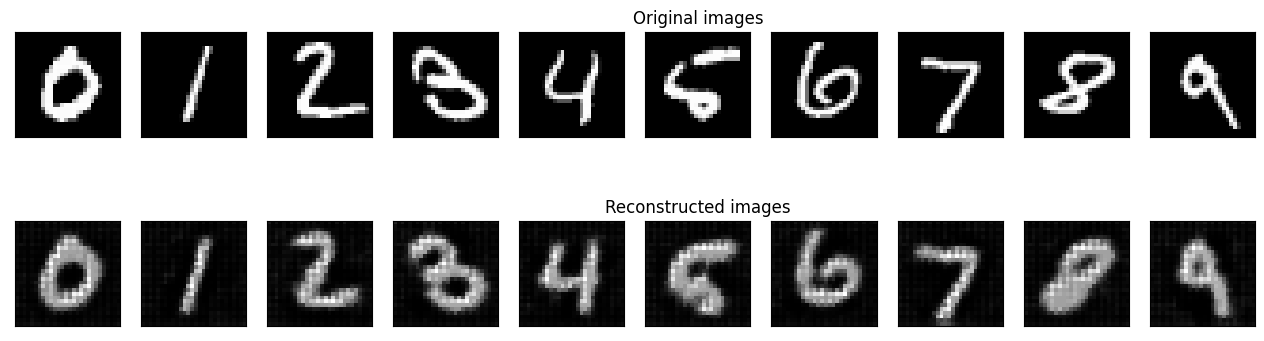

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 7/40 	 train loss 0.000117 	 val loss 0.000112


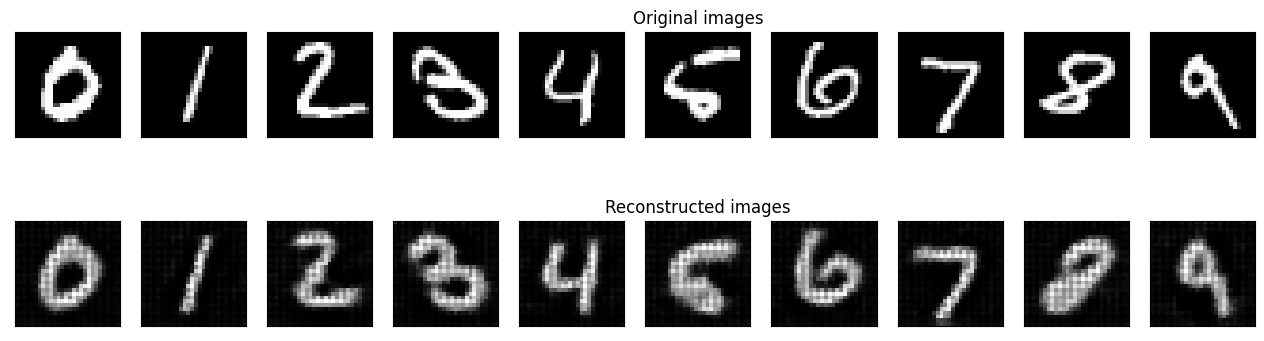

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 8/40 	 train loss 0.000105 	 val loss 0.000100


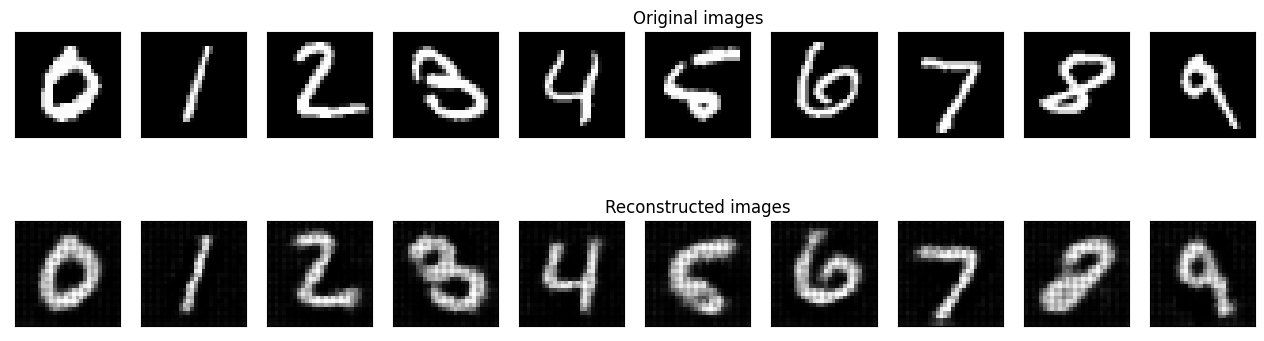

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 9/40 	 train loss 0.000096 	 val loss 0.000094


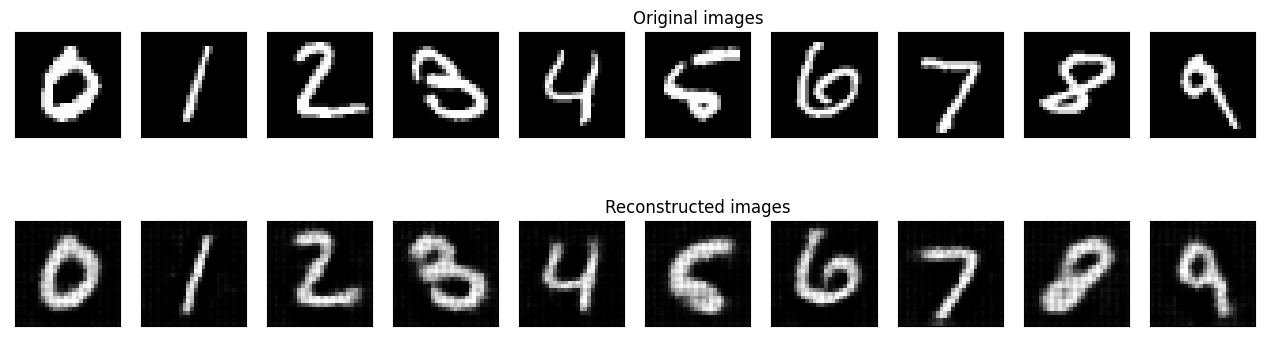

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 10/40 	 train loss 0.000091 	 val loss 0.000091


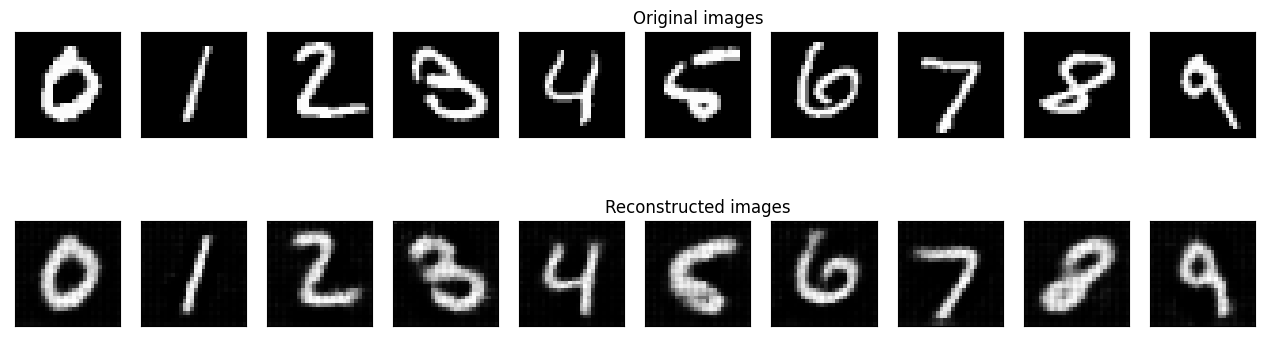

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 11/40 	 train loss 0.000088 	 val loss 0.000089


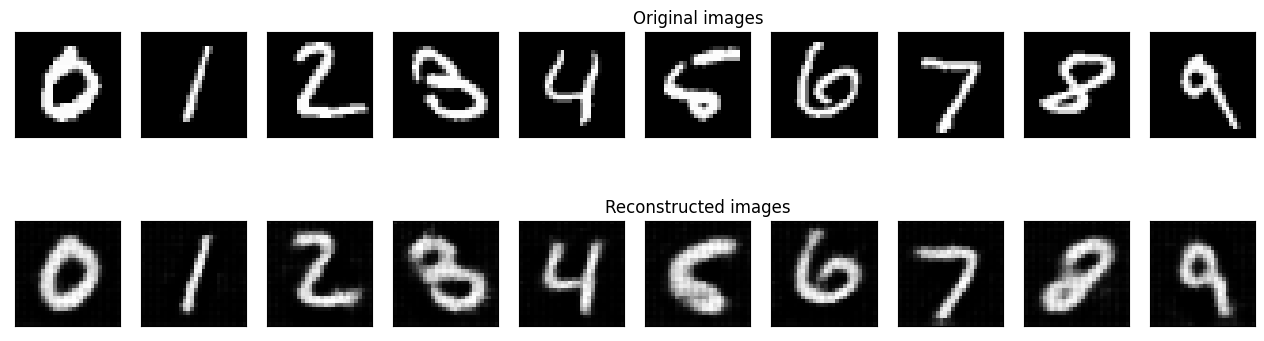

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 12/40 	 train loss 0.000086 	 val loss 0.000087


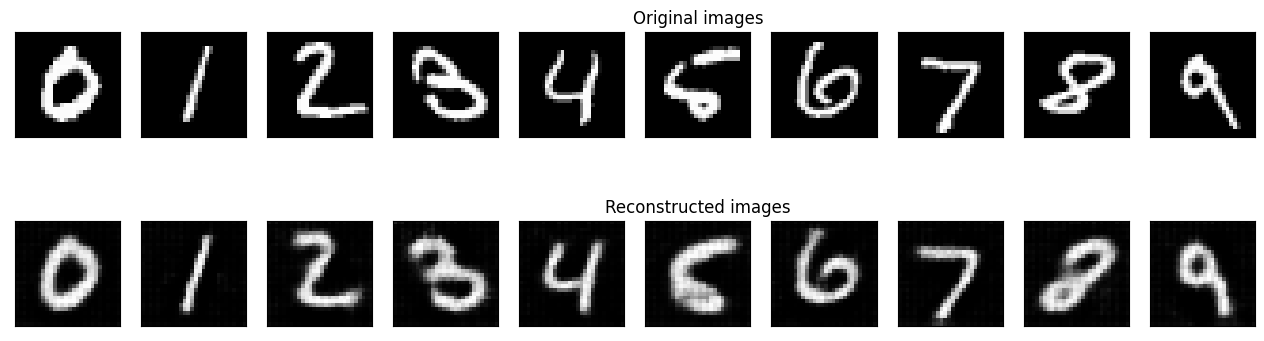

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 13/40 	 train loss 0.000085 	 val loss 0.000085


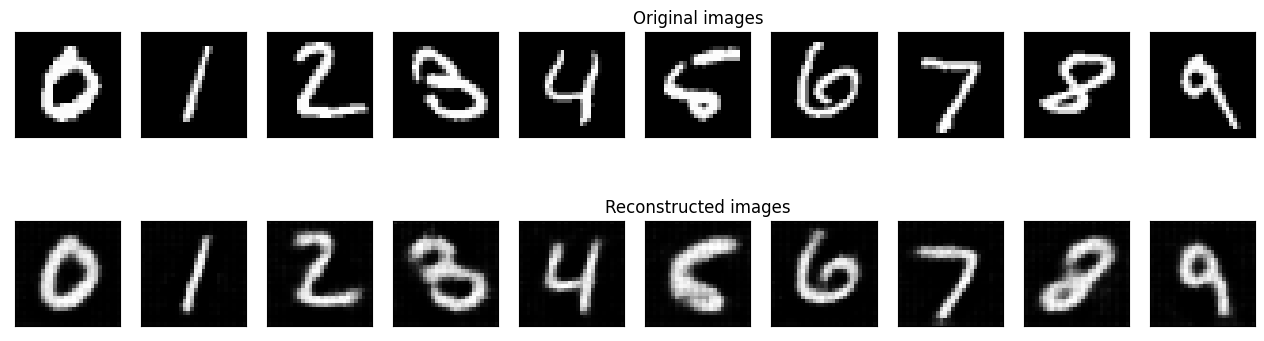

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 14/40 	 train loss 0.000084 	 val loss 0.000086


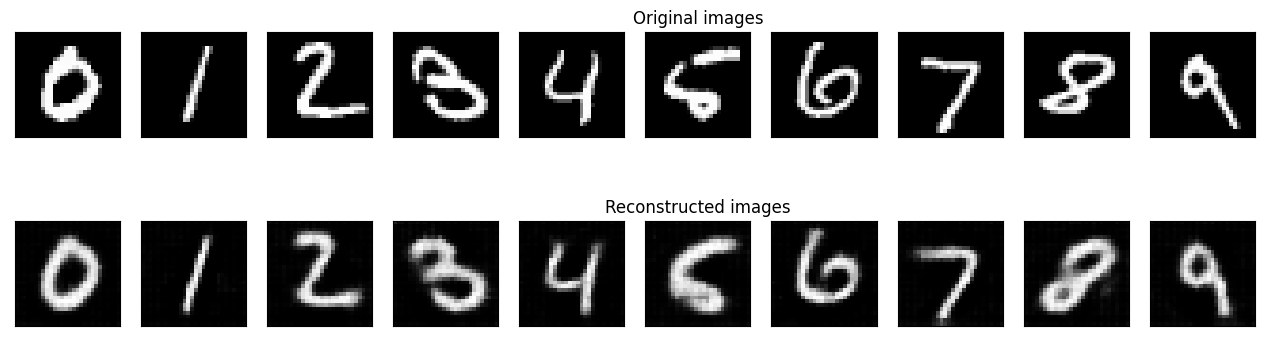

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 15/40 	 train loss 0.000083 	 val loss 0.000084


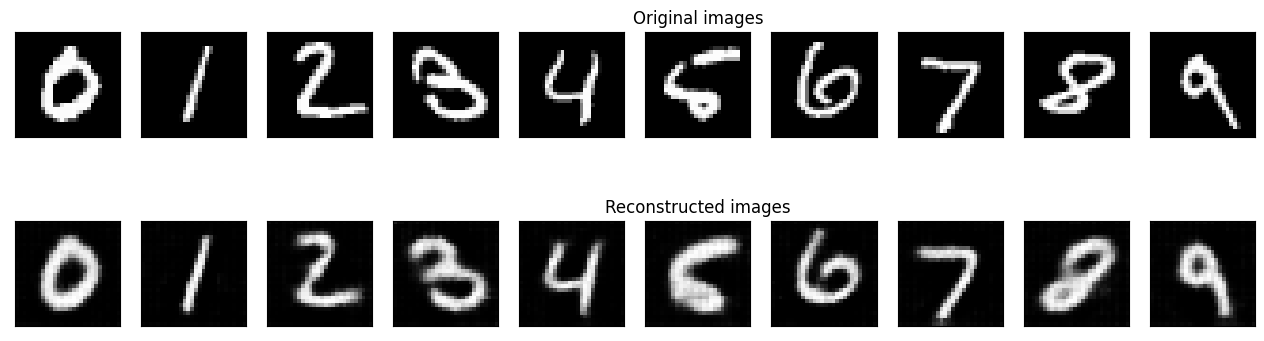

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 16/40 	 train loss 0.000082 	 val loss 0.000083


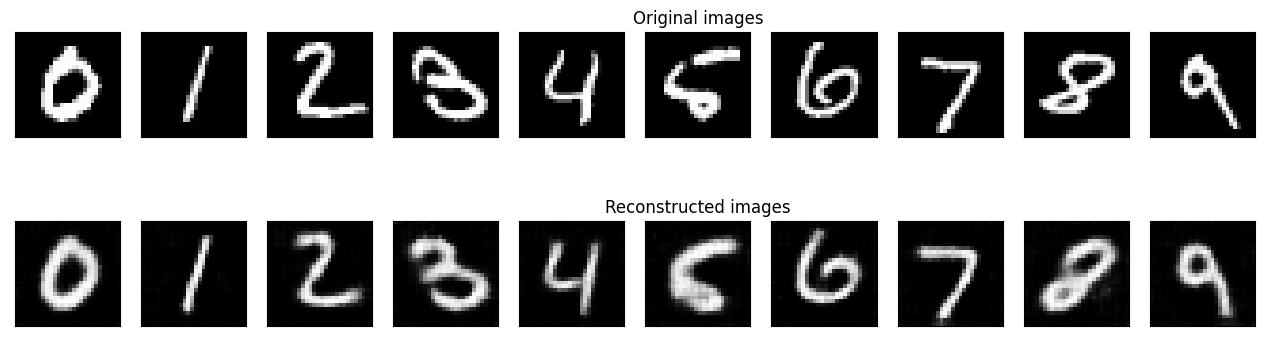

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 17/40 	 train loss 0.000081 	 val loss 0.000082


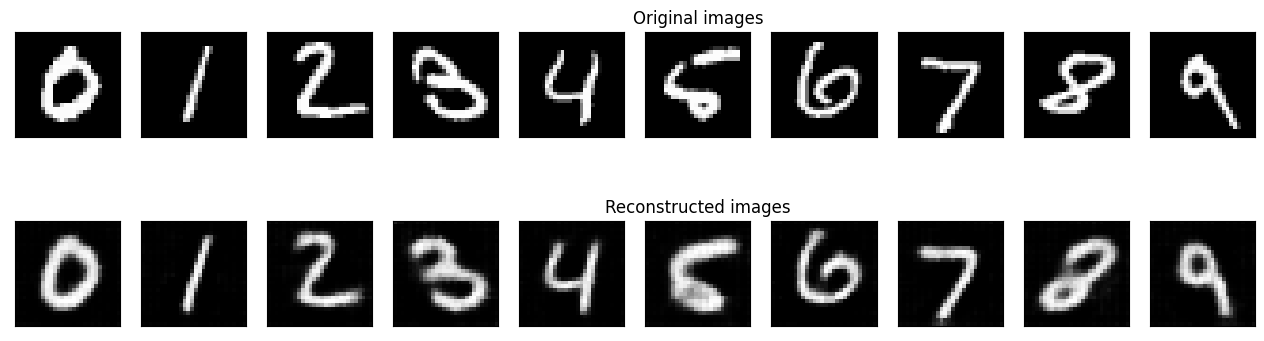

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 18/40 	 train loss 0.000081 	 val loss 0.000083


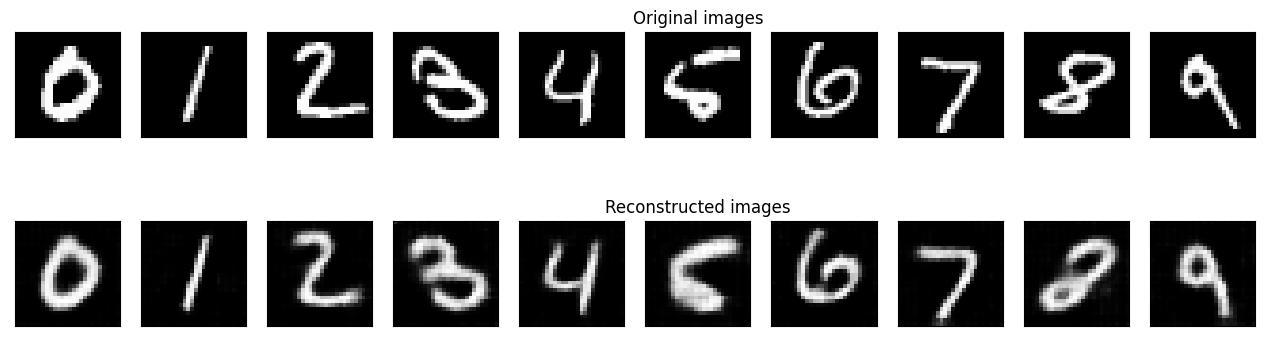

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 19/40 	 train loss 0.000080 	 val loss 0.000083


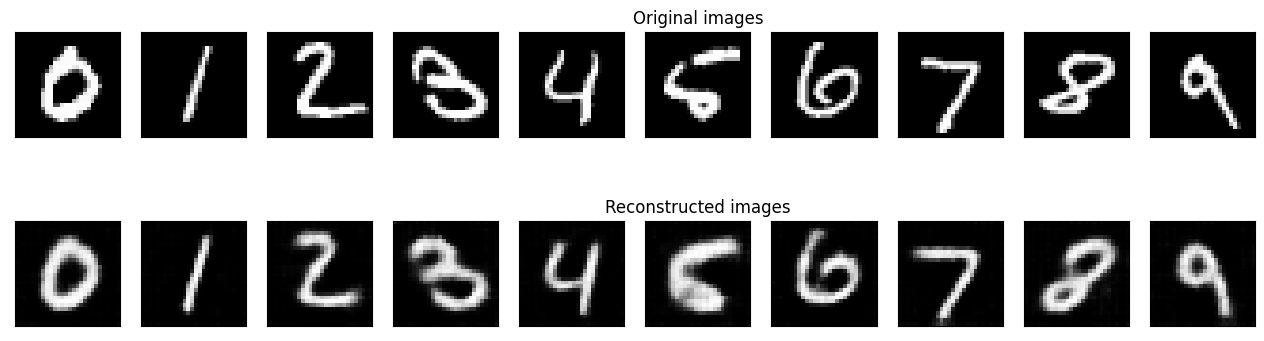

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 20/40 	 train loss 0.000080 	 val loss 0.000082


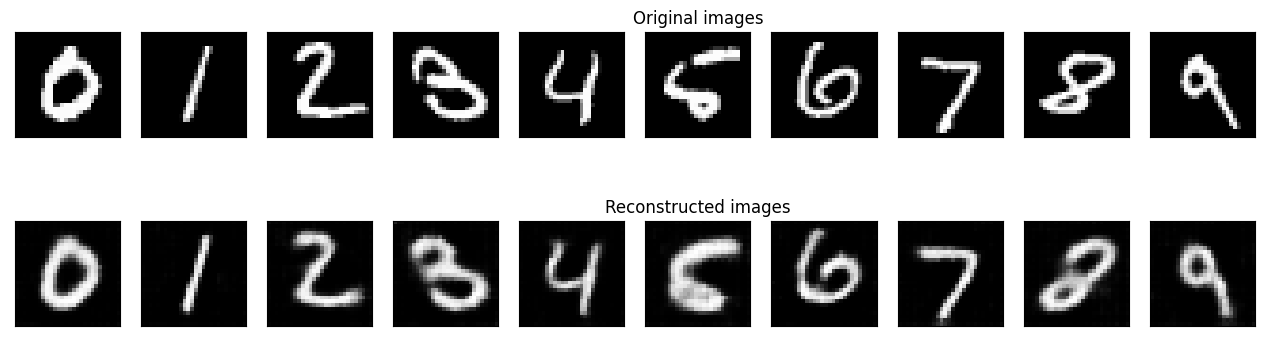

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 21/40 	 train loss 0.000079 	 val loss 0.000081


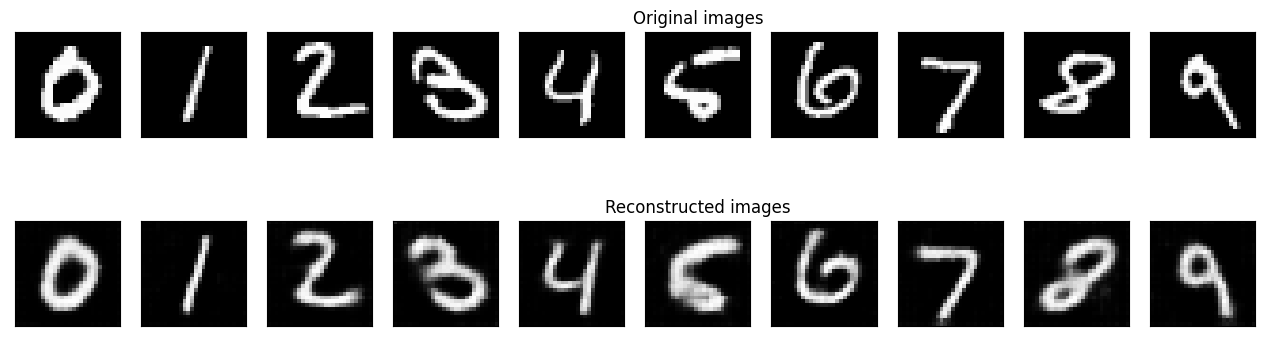

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 22/40 	 train loss 0.000079 	 val loss 0.000081


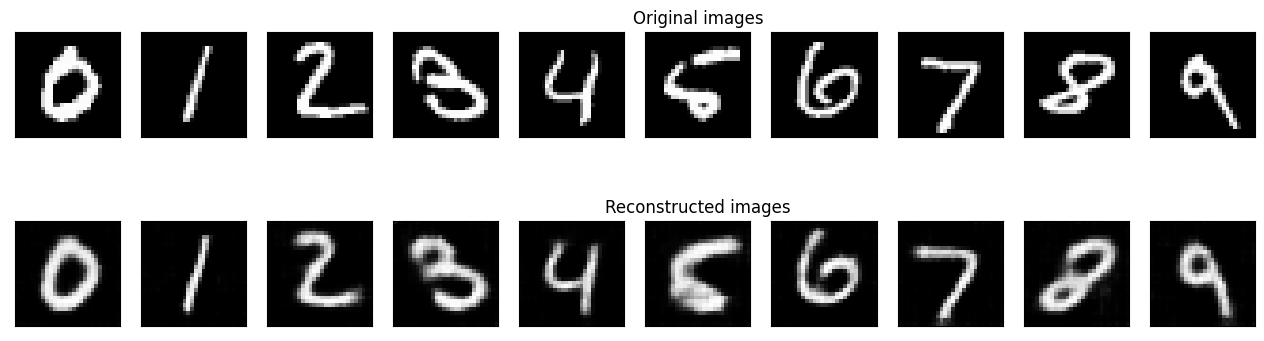

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 23/40 	 train loss 0.000079 	 val loss 0.000080


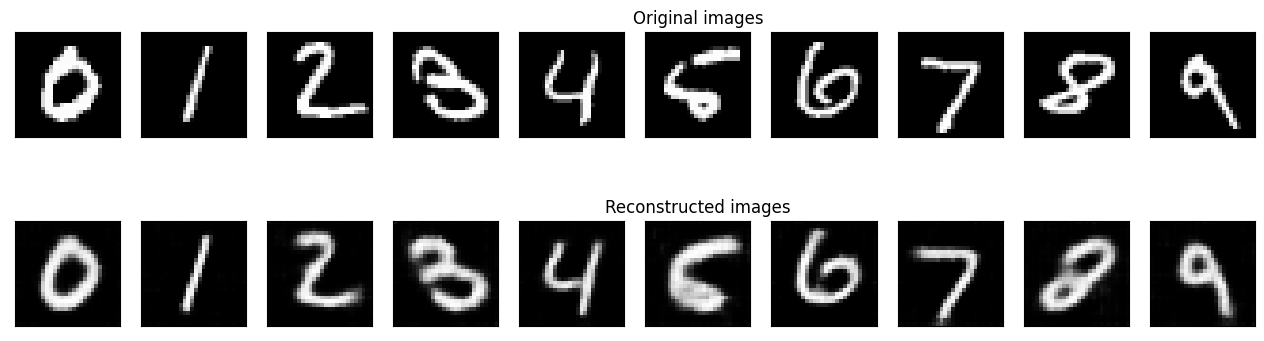

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 24/40 	 train loss 0.000078 	 val loss 0.000079


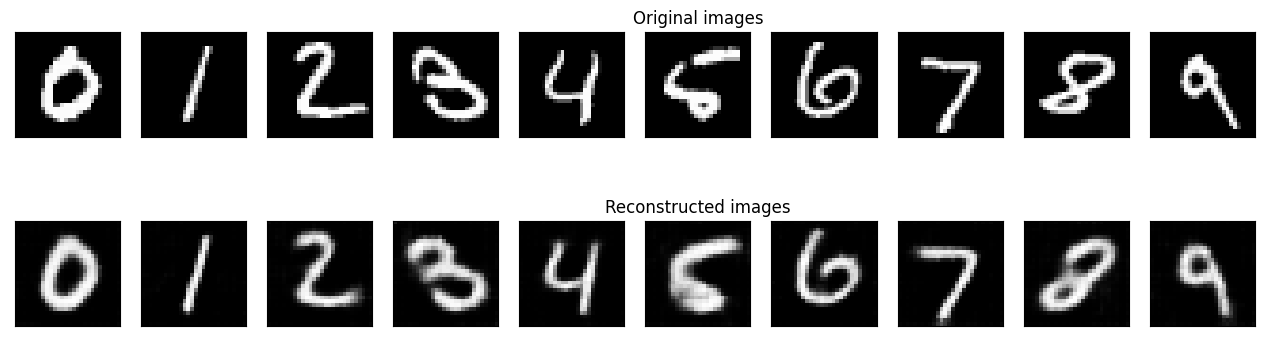

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 25/40 	 train loss 0.000078 	 val loss 0.000082


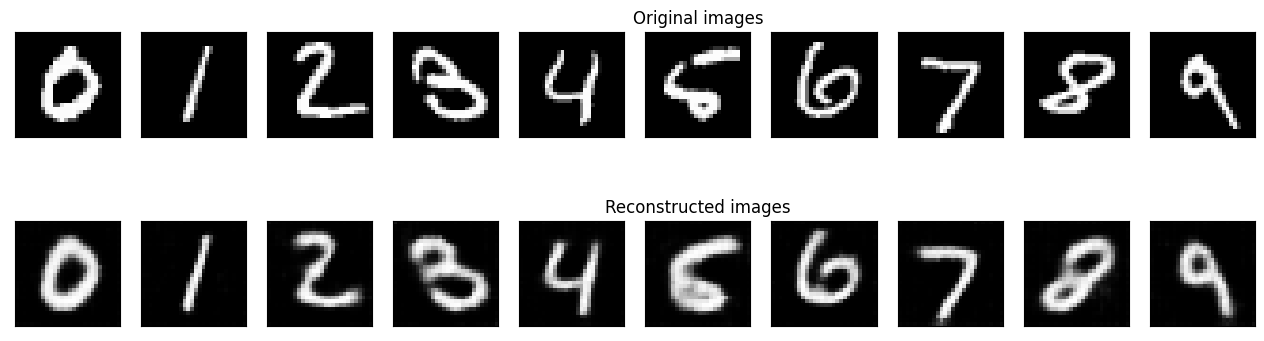

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 26/40 	 train loss 0.000078 	 val loss 0.000079


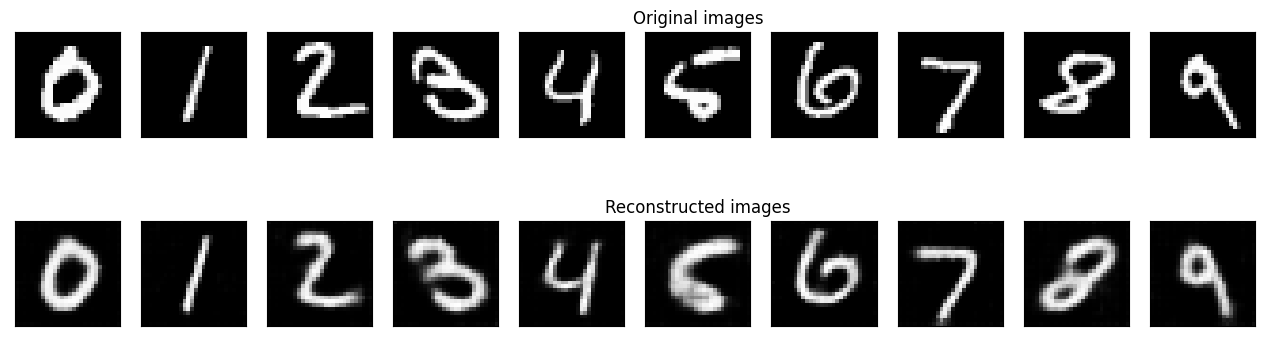

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 27/40 	 train loss 0.000077 	 val loss 0.000079


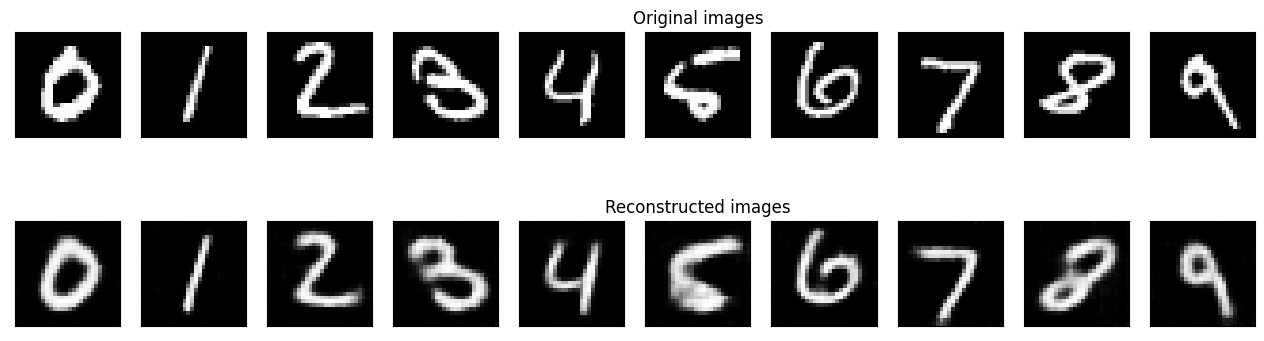

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 28/40 	 train loss 0.000077 	 val loss 0.000079


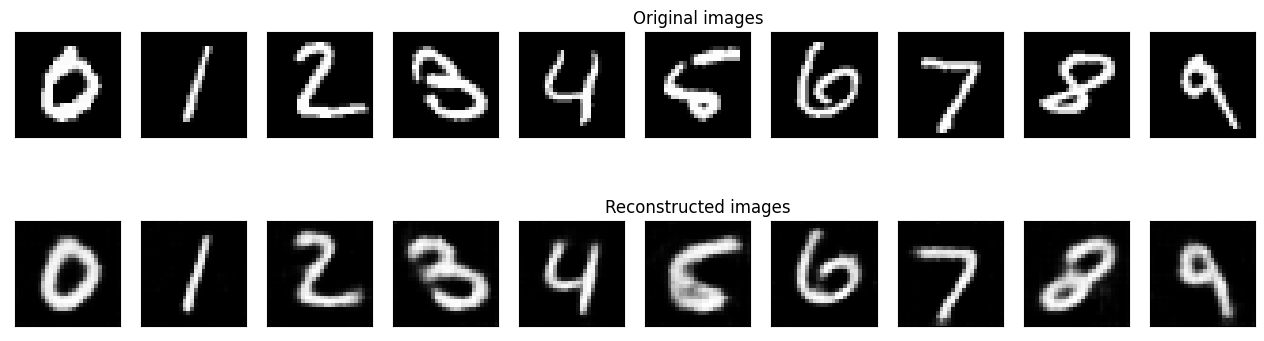

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 29/40 	 train loss 0.000077 	 val loss 0.000079


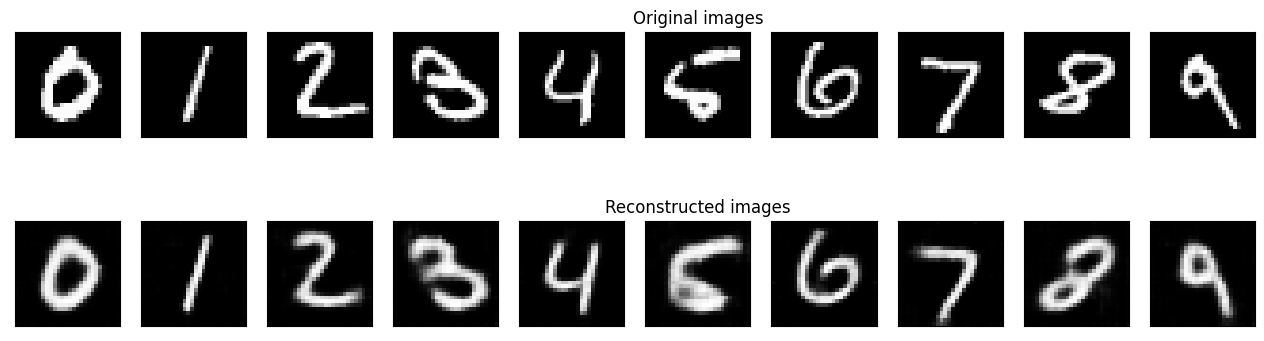

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 30/40 	 train loss 0.000077 	 val loss 0.000079


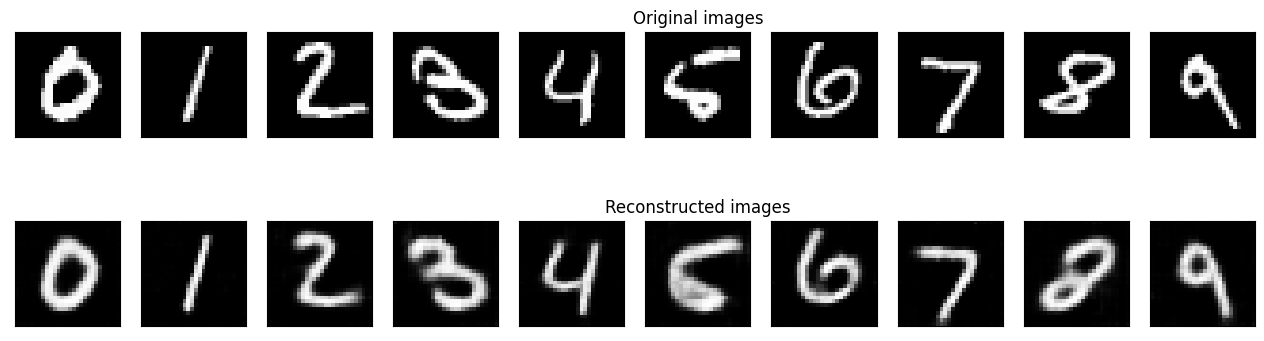

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 31/40 	 train loss 0.000076 	 val loss 0.000079


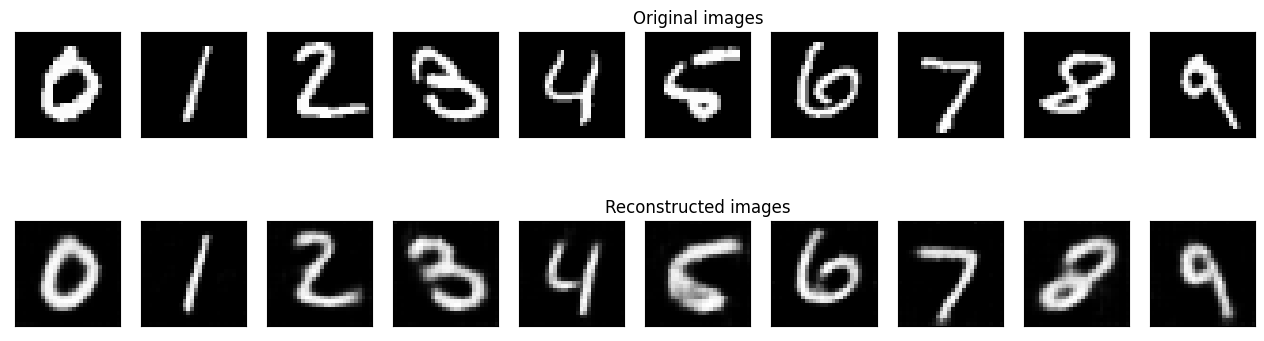

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 32/40 	 train loss 0.000076 	 val loss 0.000079


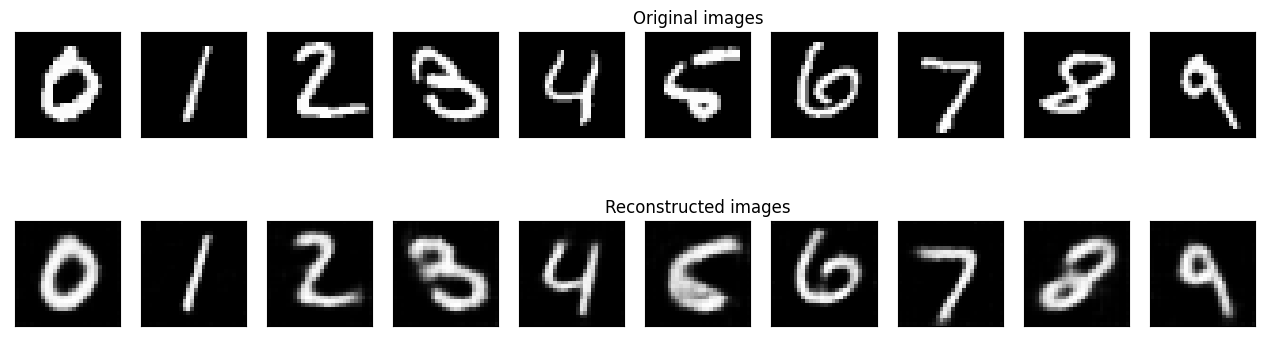

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 33/40 	 train loss 0.000076 	 val loss 0.000078


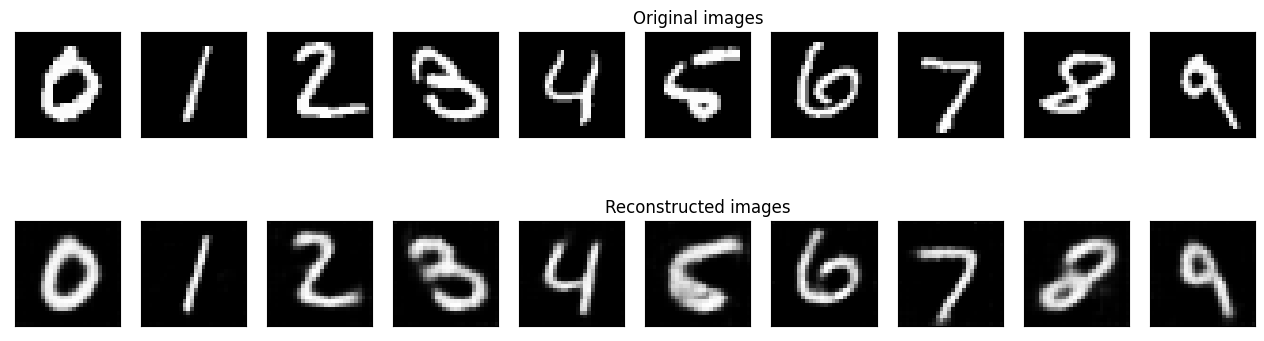

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 34/40 	 train loss 0.000076 	 val loss 0.000078


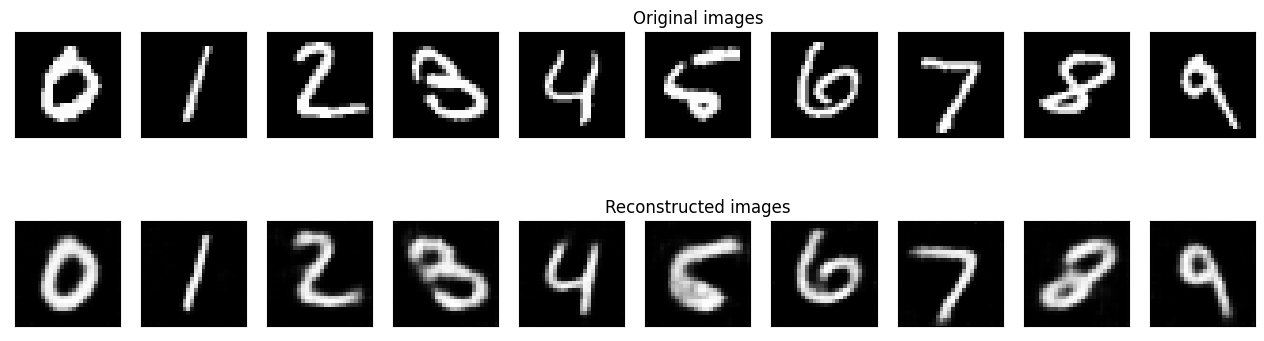

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 35/40 	 train loss 0.000075 	 val loss 0.000078


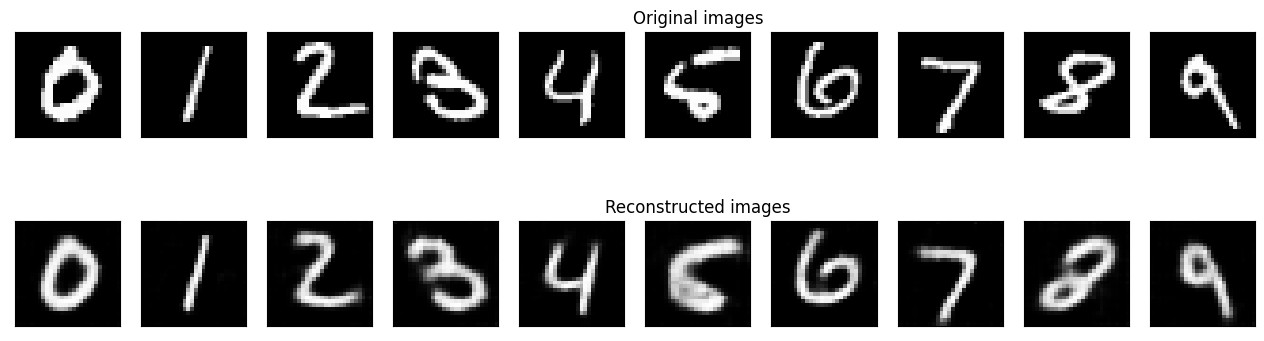

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 36/40 	 train loss 0.000075 	 val loss 0.000078


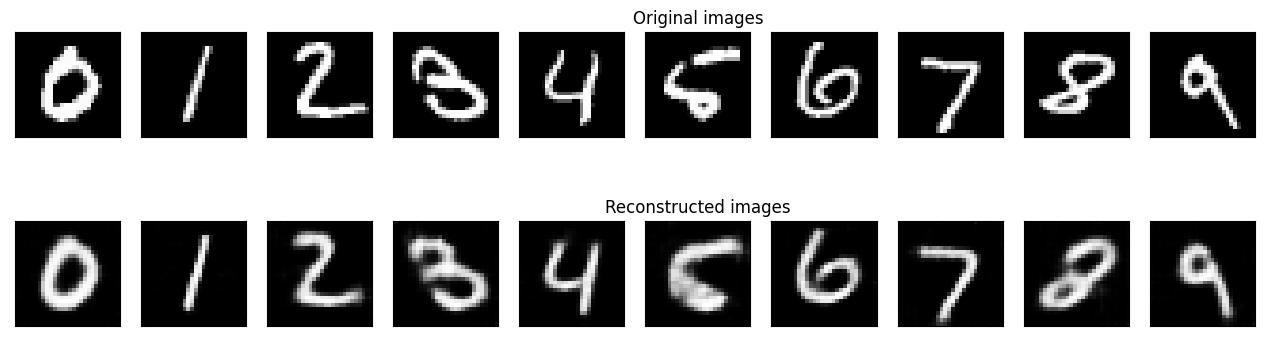

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 37/40 	 train loss 0.000075 	 val loss 0.000080


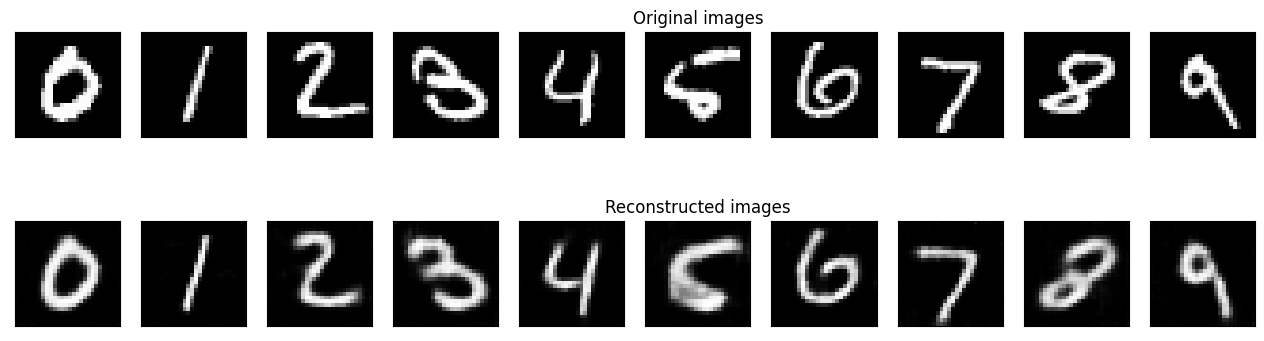

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 38/40 	 train loss 0.000075 	 val loss 0.000079


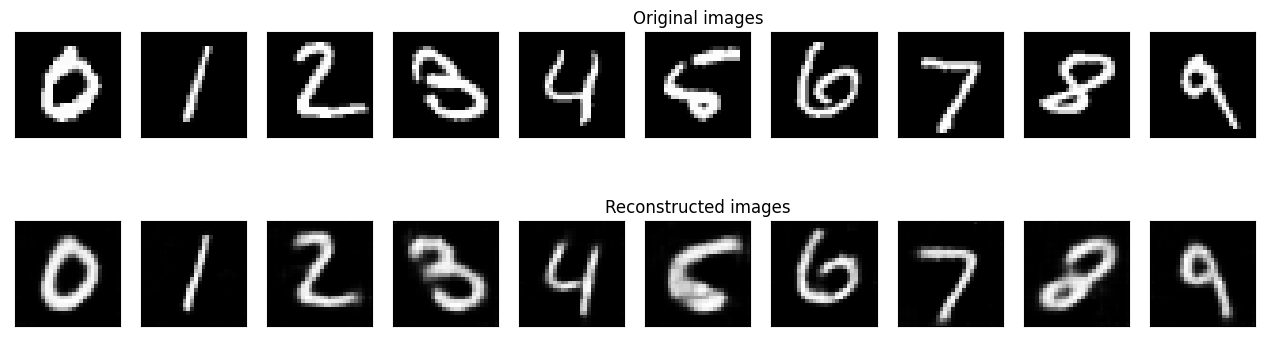

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 39/40 	 train loss 0.000075 	 val loss 0.000077


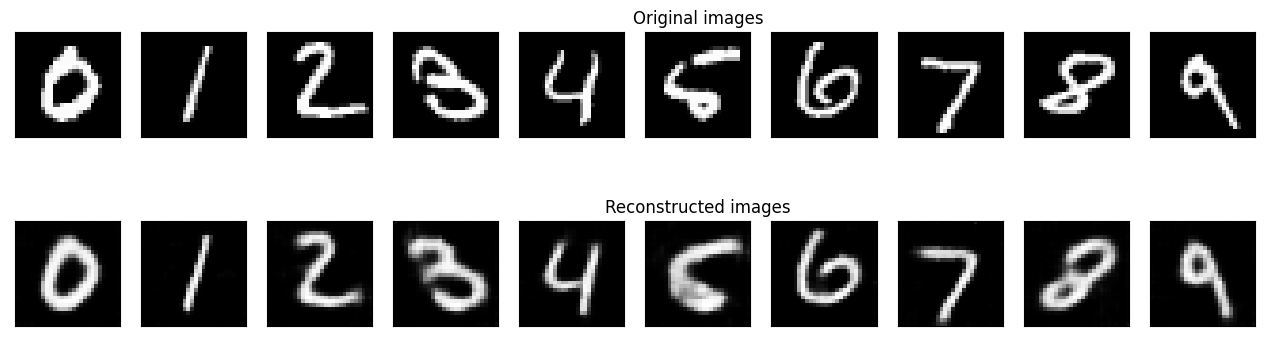

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]


 EPOCH 40/40 	 train loss 0.000075 	 val loss 0.000079


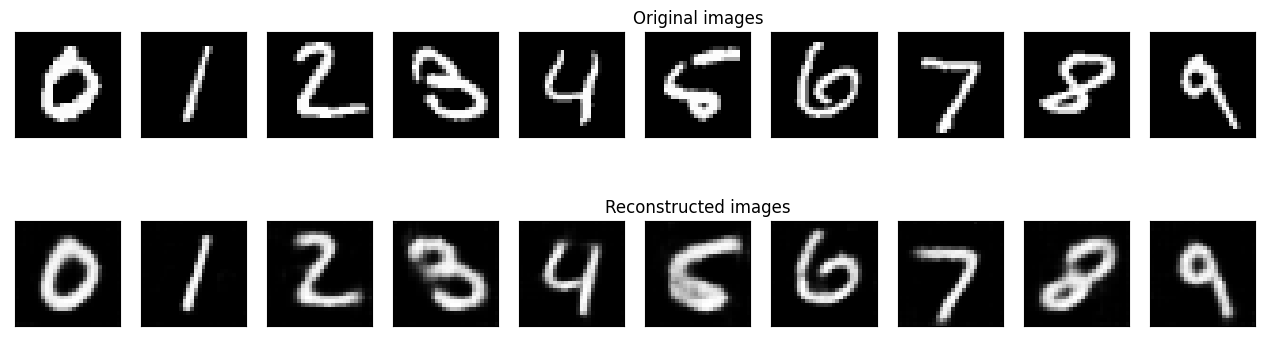

In [11]:
num_epochs = 40

for epoch in range(num_epochs):
    train_loss = train_epoch(vae, device, train_loader, optim)
    val_loss = test_epoch(vae, device, valid_loader)
    print('\n EPOCH {}/{} \t train loss {:.6f} \t val loss {:.6f}'.format(epoch + 1, num_epochs, train_loss, val_loss))
    plot_ae_outputs(vae.encoder, vae.decoder, n=10)

# Обучаем классификатор на скрытых представлениях

In [12]:
def prepare_data(data):
    X, Y = [], []
    vae.eval()
    for d in tqdm(data):
        x, y = d
        x = x.unsqueeze(0).to(device)
        with torch.no_grad():
            encoded_data = vae.encoder(x)
        X.append(encoded_data.cpu().numpy().reshape(-1))
        Y.append(y)
    
    return np.array(X), np.array(Y)

In [13]:
X_train, y_train = prepare_data(train_data)
X_val, y_val = prepare_data(val_data)
X_test, y_test = prepare_data(test_dataset)

transformer = StandardScaler()
X_train = transformer.fit_transform(X_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

  0%|          | 0/48000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
model = CatBoostClassifier(iterations=2000, learning_rate=0.05,
                           loss_function='MultiClass', verbose=300,
                           task_type="GPU", devices='0:1',
                           custom_metric=['Accuracy', 'Precision', 'F1'])
model.fit(X_train, y_train, eval_set=(X_val, y_val))

y_pred = model.predict(X_test)
print('Test Score')
print(classification_report(y_test, y_pred))

0:	learn: 2.0382944	test: 2.0389932	best: 2.0389932 (0)	total: 16ms	remaining: 32s
300:	learn: 0.1562125	test: 0.1893841	best: 0.1893841 (300)	total: 3.36s	remaining: 19s
600:	learn: 0.1280764	test: 0.1725493	best: 0.1725493 (600)	total: 6.72s	remaining: 15.7s
900:	learn: 0.1126767	test: 0.1670330	best: 0.1670330 (900)	total: 10.2s	remaining: 12.4s
1200:	learn: 0.1009628	test: 0.1649459	best: 0.1649459 (1200)	total: 13.6s	remaining: 9.05s
1500:	learn: 0.0916209	test: 0.1638711	best: 0.1638499 (1497)	total: 17.1s	remaining: 5.7s
1800:	learn: 0.0836693	test: 0.1639733	best: 0.1637871 (1620)	total: 20.6s	remaining: 2.27s
1999:	learn: 0.0786679	test: 0.1640886	best: 0.1637871 (1620)	total: 22.8s	remaining: 0us
bestTest = 0.1637871297
bestIteration = 1620
Shrink model to first 1621 iterations.
Test Score
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96   

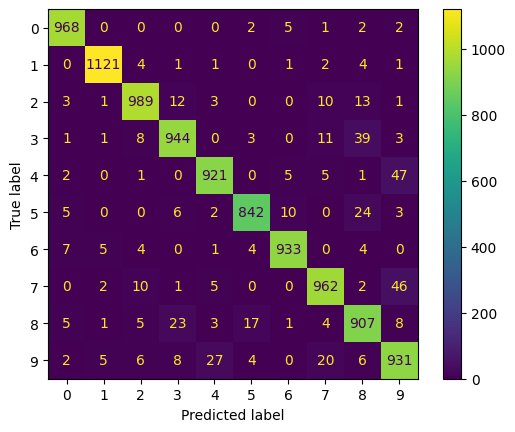

In [15]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

# Для сравнения обучим тот же классификатор на исходных данных

In [16]:
def prepare_data(data):
    X, Y = [], []
    for d in tqdm(data):
        x, y = d
        X.append(x.numpy().reshape(-1))
        Y.append(y)
    
    return np.array(X), np.array(Y)

In [17]:
X_train, y_train = prepare_data(train_data)
X_val, y_val = prepare_data(val_data)
X_test, y_test = prepare_data(test_dataset)

transformer = StandardScaler()
X_train = transformer.fit_transform(X_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

  0%|          | 0/48000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
model = CatBoostClassifier(iterations=2000, learning_rate=0.05,
                           loss_function='MultiClass', verbose=300,
                           leaf_estimation_method='Newton', l2_leaf_reg=1,
                           task_type="GPU", devices='0:1',
                           custom_metric=['Accuracy', 'Precision', 'F1'])
model.fit(X_train, y_train, eval_set=(X_val, y_val))

y_pred = model.predict(X_test)
print('Test Score')
print(classification_report(y_test, y_pred))

0:	learn: 2.1370949	test: 2.1387795	best: 2.1387795 (0)	total: 31ms	remaining: 1m 2s
300:	learn: 0.1420881	test: 0.1719390	best: 0.1719390 (300)	total: 7.01s	remaining: 39.6s
600:	learn: 0.1059512	test: 0.1410572	best: 0.1410572 (600)	total: 12.9s	remaining: 30.1s
900:	learn: 0.0853422	test: 0.1250914	best: 0.1250914 (900)	total: 19s	remaining: 23.2s
1200:	learn: 0.0694650	test: 0.1135543	best: 0.1135543 (1200)	total: 25.1s	remaining: 16.7s
1500:	learn: 0.0584432	test: 0.1064568	best: 0.1064568 (1500)	total: 31.2s	remaining: 10.4s
1800:	learn: 0.0484449	test: 0.0999560	best: 0.0999560 (1800)	total: 37.6s	remaining: 4.15s
1999:	learn: 0.0430615	test: 0.0965374	best: 0.0965374 (1999)	total: 41.8s	remaining: 0us
bestTest = 0.09653739421
bestIteration = 1999
Test Score
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
       

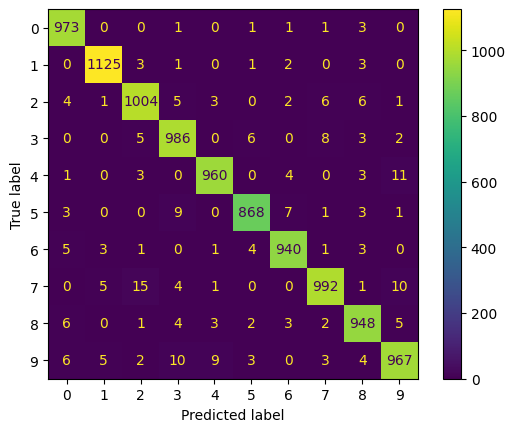

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

# Также для сравнения обучим тот же классификатор на данных, выдоваемых автоэнкодером

In [20]:
def prepare_data(data):
    X, Y = [], []
    vae.eval()
    for d in tqdm(data):
        x, y = d
        x = x.unsqueeze(0).to(device)
        with torch.no_grad():
            data = vae(x)
        X.append(data.cpu().numpy().reshape(-1))
        Y.append(y)
    
    return np.array(X), np.array(Y)

In [21]:
X_train, y_train = prepare_data(train_data)
X_val, y_val = prepare_data(val_data)
X_test, y_test = prepare_data(test_dataset)

transformer = StandardScaler()
X_train = transformer.fit_transform(X_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

  0%|          | 0/48000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
model = CatBoostClassifier(iterations=2000, learning_rate=0.05,
                           loss_function='MultiClass', verbose=300,
                           leaf_estimation_method='Newton', l2_leaf_reg=1,
                           task_type="GPU", devices='0:1',
                           custom_metric=['Accuracy', 'Precision', 'F1'])
model.fit(X_train, y_train, eval_set=(X_val, y_val))

y_pred = model.predict(X_test)
print('Test Score')
print(classification_report(y_test, y_pred))

0:	learn: 2.1041289	test: 2.1091486	best: 2.1091486 (0)	total: 32.4ms	remaining: 1m 4s
300:	learn: 0.1450882	test: 0.1905214	best: 0.1905214 (300)	total: 8.06s	remaining: 45.5s
600:	learn: 0.1114895	test: 0.1727268	best: 0.1727268 (600)	total: 15.5s	remaining: 36s
900:	learn: 0.0923393	test: 0.1666422	best: 0.1666422 (900)	total: 22.7s	remaining: 27.7s
1200:	learn: 0.0777364	test: 0.1636003	best: 0.1636003 (1200)	total: 30.1s	remaining: 20s
1500:	learn: 0.0656397	test: 0.1623774	best: 0.1623600 (1494)	total: 37.5s	remaining: 12.5s
1800:	learn: 0.0561445	test: 0.1619396	best: 0.1619083 (1702)	total: 45s	remaining: 4.97s
1999:	learn: 0.0505005	test: 0.1619820	best: 0.1618018 (1854)	total: 50s	remaining: 0us
bestTest = 0.161801768
bestIteration = 1854
Shrink model to first 1855 iterations.
Test Score
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97     

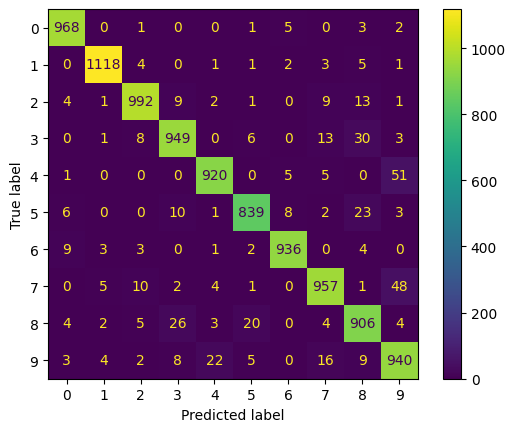

In [23]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

# Вывод

Видно, что в автоэнкодере данные теряют часть значимых признаков, поэтому классификатор на скрытых представлениях справляется хуже. Это видно по ков. матрице и по тому, что предсказывает автоэнкодер, некоторые цифры "переходят" в другие, например 4 в 9 и т.д. В качестве размерности скрытого представления была выбрана размерность 6, так как при такой размерности автоэнкодер еще не копирует искходные данные, но и может отрисовать цифру очень приближенно к исходной.

Идеи для улучшения: Попробовать RBM: https://towardsdatascience.com/improving-autoencoder-performance-with-pretrained-rbms-e2e13113c782
